<a href="https://colab.research.google.com/github/mejiyuh/4116-Midterm/blob/main/Github_4116Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Train Data Subdirectories:
['DME', 'DRUSEN']
Test Data Subdirectories:
['DME', 'DRUSEN']
Tiny train Data Subdirectories:
['DME', 'DRUSEN']
Tiny test Data Subdirectories:
['DME', 'DRUSEN']
Found 13386 images belonging to 2 classes.
Found 5736 images belonging to 2 classes.
Found 930 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/210 ━━━━━━━━━━━━━━━━━━━━ 166s 698ms/step - accuracy: 0.8425 - loss: 0.3431 - val_accuracy: 0.7136 - val_loss: 1.1338 - learning_rate: 0.0010
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 641ms/step - accuracy: 0.9277 - loss: 0.1736 - val_accuracy: 0.8867 - val_loss: 0.3249 - learning_rate: 0.0010
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 640ms/step - accuracy: 0.9359 - loss: 0.1563 - val_accuracy: 0.8813 - val_loss: 0.3111 - learning_rate: 0.0010
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 640ms/step - accuracy: 0.9468 - loss: 0.1372 - val_accuracy: 0.9376 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 639ms/step - accuracy: 0.9553 - loss: 0.1217 - val_accuracy: 0.8893 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 640ms/step - accuracy: 0.9550 - loss: 0.1133 - val_accuracy: 0.9123 - val_loss: 0.2166 - learning_rate: 0.0010
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 137s 638ms/step - accuracy: 0.9553 

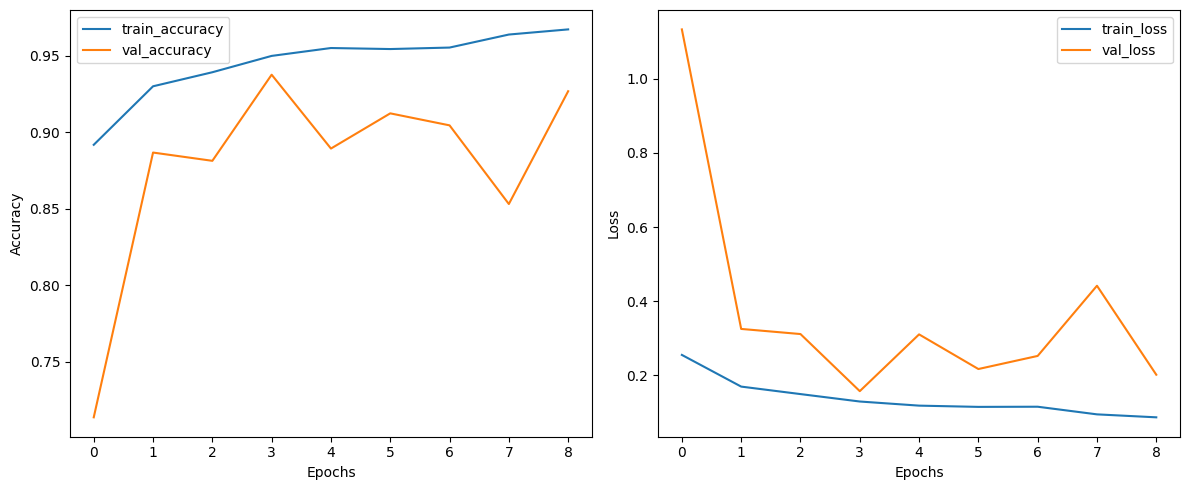

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step


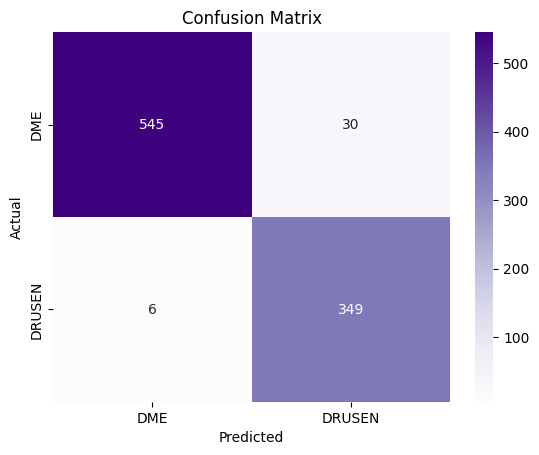

In [1]:
from google.colab import drive
import shutil

#mount google drive
drive.mount('/content/drive')

# Paths for the datasets
train_data_dir = '/content/drive/My Drive/Data'  # default dataset
tiny_data_dir = '/content/drive/My Drive/Data_Small/train'  # tiny dataset train
test_tiny_data_dir = '/content/drive/My Drive/Data_Small/test'  # tiny dataset test

#copying datasets to local storage for faster access (hoping for)
shutil.copytree(train_data_dir, '/content/Data')
shutil.copytree(tiny_data_dir, '/content/Data_Small/train')
shutil.copytree(test_tiny_data_dir, '/content/Data_Small/test')

train_data_dir = '/content/Data/Data/train'
test_data_dir = '/content/Data/Data/test'
train_tiny_data_dir = '/content/Data_Small/train'
test_tiny_data_dir = '/content/Data_Small/test'

import os

print("Train Data Subdirectories:")
print(os.listdir(train_data_dir))
print("Test Data Subdirectories:")
print(os.listdir(test_data_dir))

print("Tiny train Data Subdirectories:")
print(os.listdir(tiny_data_dir))
print("Tiny test Data Subdirectories:")
print(os.listdir(test_tiny_data_dir))

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-4


def preprocess_and_convert(image):
    #normalization
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    image = (image - mean) / std

    #rgb check
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    return image

#data generators for training/validation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_convert,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_and_convert
)

train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
#convert to a tf.data dataset (in hopes of improving runtime)
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    return dataset

train_dataset = generator_to_dataset(train_generator).cache().prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = generator_to_dataset(validation_generator).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = generator_to_dataset(test_generator).cache().prefetch(tf.data.experimental.AUTOTUNE)

#class weights for imbalanced data
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

#load model (used VGG19 instead of ResNet50)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers[:-4]:  #freeze layers in base model
    layer.trainable = False

#custom layers for classification.
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)
#final model
model = Model(inputs=base_model.input, outputs=output)

#compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#callbacks-added lr_scheduler
checkpoint = ModelCheckpoint('best_model_vgg19.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)


#train the model
#Google Colab GPU compute units :/
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, checkpoint],
    class_weight=class_weight_dict
)

#test set evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#plot training/validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plot training/validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#confusion Matrix
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [2]:
#evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.920844327176781
Recall: 0.9830985915492958
F1 Score: 0.9509536784741145


In [3]:
from sklearn.metrics import classification_report
#predictions for the test set
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes
#class distribution in the test set
print("\nClass distribution in the test set:")
for class_name, class_index in test_generator.class_indices.items():
    class_count = np.sum(true_classes == class_index)
    print(f"{class_name}: {class_count}")

#classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys())))

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step

Class distribution in the test set:
DME: 575
DRUSEN: 355

Classification Report:
              precision    recall  f1-score   support

         DME       0.99      0.95      0.97       575
      DRUSEN       0.92      0.98      0.95       355

    accuracy                           0.96       930
   macro avg       0.95      0.97      0.96       930
weighted avg       0.96      0.96      0.96       930



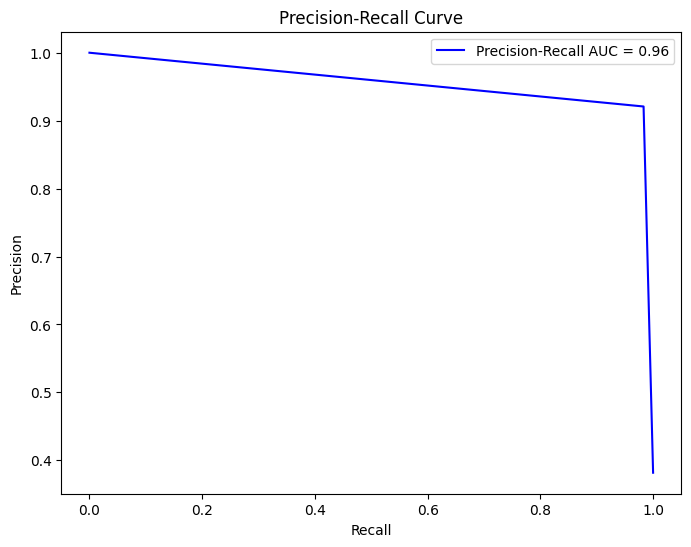

In [4]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

#precision-recall curve for the positive class
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 0])
pr_auc = auc(recall, precision)

#plot curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')
plt.show()

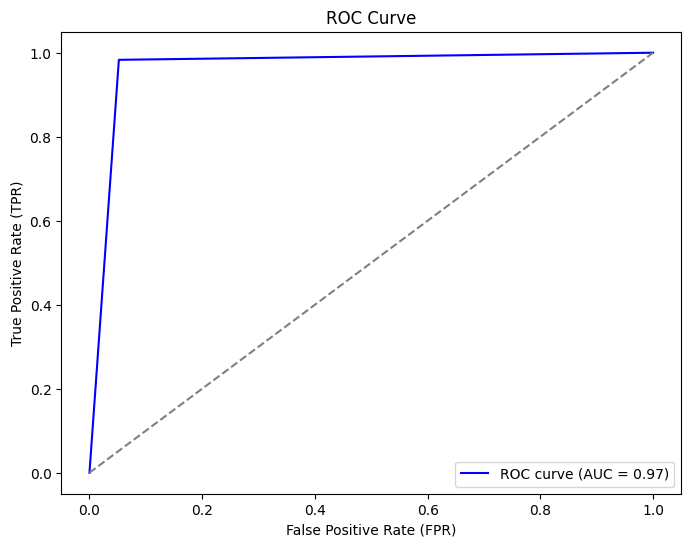

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#predicted probabilities for the positive class
y_pred_prob = y_pred[:, 0]  # Single output, class 1 probabilities

#calculations for ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

#plot curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
